In [1]:
# modules imports
import numpy as np
from spectral_cube import SpectralCube as sc
import astropy.io.fits as fits
import astropy.io
from astropy.wcs import WCS
import os
import sys
import math
import copy
import time
import numpy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import six
import aplpy
from astropy import units as u

In [2]:
# set default formats
font = 'Times New Roman'
plt.rcParams['font.size'] = 20
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = font
plt.rcParams['mathtext.it'] = font + ':italic'
plt.rcParams['mathtext.bf'] = font + ':bold'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

In [3]:
path = "/Users/r.yamada/science/NGC2023_13CO_Tmb_rot30_starcentered.fits"

In [4]:
hdu = fits.open(path)[0]
header=hdu.header
data=hdu.data

In [5]:
wcs = WCS(hdu)
header["CTYPE3"] = "VELO-LSR"
header["CTYPE1"] = "GLON    "
header["CTYPE2"] = "GLAT    "
header["BUNIT"] = "K       "
header["BMAJ"] = 0.0038888888888888888


hdu_fixed = fits.PrimaryHDU(data,header)
cube = sc.read(hdu_fixed)
subcube = cube.spectral_slab(10.8 * u.km / u.s, 13.9 * u.km / u.s) 
subcube = subcube.with_spectral_unit(u.km / u.s)
cubemap=subcube.moment(order=0)



In [6]:
from astropy import units as u
mask = subcube > 0.37*6*u.K 
subcube = subcube.with_mask(mask)
firstmoment_cube=subcube.moment(order=1)
secondmoment_cube=subcube.moment(order=2)

/Users/r.yamada/ymdfits/.venv/lib/python3.7/site-packages/spectral_cube/masks.py:711: RuntimeWarning: invalid value encountered in greater
  self._comparison_value)
/Users/r.yamada/ymdfits/.venv/lib/python3.7/site-packages/spectral_cube/_moments.py:169: RuntimeWarning: invalid value encountered in true_divide
  np.nansum(data, axis=axis))
/Users/r.yamada/ymdfits/.venv/lib/python3.7/site-packages/spectral_cube/_moments.py:179: RuntimeWarning: invalid value encountered in true_divide
  np.nansum(data, axis=axis))


INFO: Auto-setting resolution to 33.4851 dpi [aplpy.core]


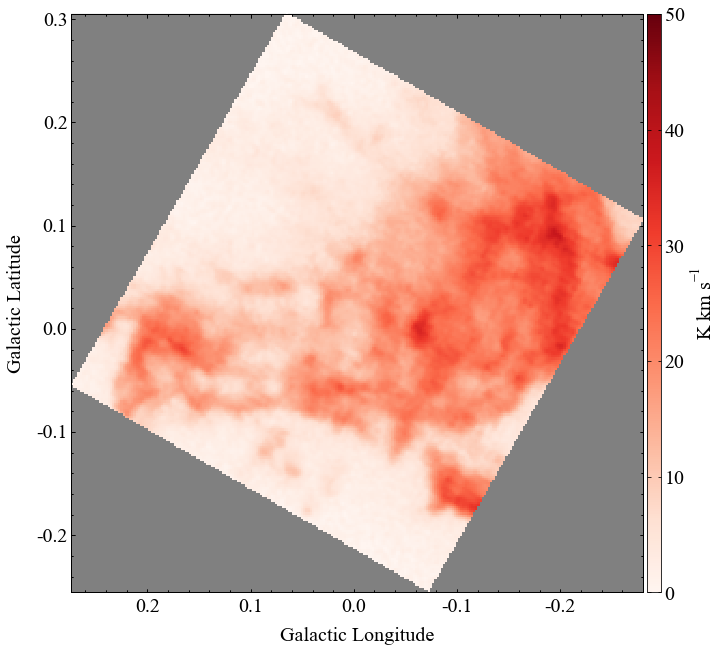

In [7]:
f = plt.figure(figsize=(24, 12))
plt.subplots_adjust(wspace=0.27, hspace=0.6)
f = aplpy.FITSFigure(cubemap.hdu, subplot=(1, 2, 1), figure=f)
f.show_colorscale(cmap='Reds',vmin=0,vmax=50)
f.add_colorbar()
f.set_xaxis_coord_type('scalar')
f.set_yaxis_coord_type('scalar')
f.ticks.set_color('black')
f.set_nan_color('grey')
f.colorbar.set_axis_label_text("K km s$^{-1}$")
f.savefig('rot30_redcloud_3.eps')


In [8]:
def xyv2ch(x, y, v, w): # km/s
    x_ch, y_ch, v_ch = w.wcs_world2pix(x, y, v*1000.0, 0) #230,0=nanndemoOK
    x_ch, y_ch, v_ch = int(round(float(x_ch))),int(round(float(y_ch))),int(round(float(v_ch)))

    return x_ch, y_ch, v_ch

In [9]:
#integrating range

print(xyv2ch(0.,0.02,0.,wcs))
print(xyv2ch(0.,0.,0.,wcs))

(131, 132, 333)
(131, 122, 333)


In [10]:
from astropy import units as u
#sub_cube = cube[:100, 10:50, 10:50]
subcube_pv = subcube[:,122:132,:]
firstmoment_cube=firstmoment_cube[122:132,:]
secondmoment_cube=secondmoment_cube[122:123,:]


print(subcube_pv)
subcube_pv1 = subcube_pv.with_spectral_unit(u.km / u.s)
cubemap_pv=subcube_pv1.moment(order=0,axis=1)

print(cubemap_pv.hdu.data)

SpectralCube with shape=(11, 10, 266) and unit=K:
 n_x:    266  type_x: GLON      unit_x: deg    range:    -0.279167 deg:    0.272917 deg
 n_y:     10  type_y: GLAT      unit_y: deg    range:     0.000000 deg:    0.018750 deg
 n_s:     11  type_s: VOPT      unit_s: km / s  range:       10.850 km / s:      13.850 km / s
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


/Users/r.yamada/ymdfits/.venv/lib/python3.7/site-packages/spectral_cube/masks.py:711: RuntimeWarning: invalid value encountered in greater
  self._comparison_value)


In [11]:
cubemap_pv.hdu.header["CTYPE2"]='VELO-LSR'
cubemap_pv.hdu.header["CRVAL2"]=cubemap_pv.hdu.header["CRVAL2"]/1000
cubemap_pv.hdu.header["CRVAL2"]=cubemap_pv.hdu.header["CDELT2"]/1000



INFO: Auto-setting vmax to  3.936e-01 [aplpy.core]
INFO: Auto-setting resolution to 32.4211 dpi [aplpy.core]


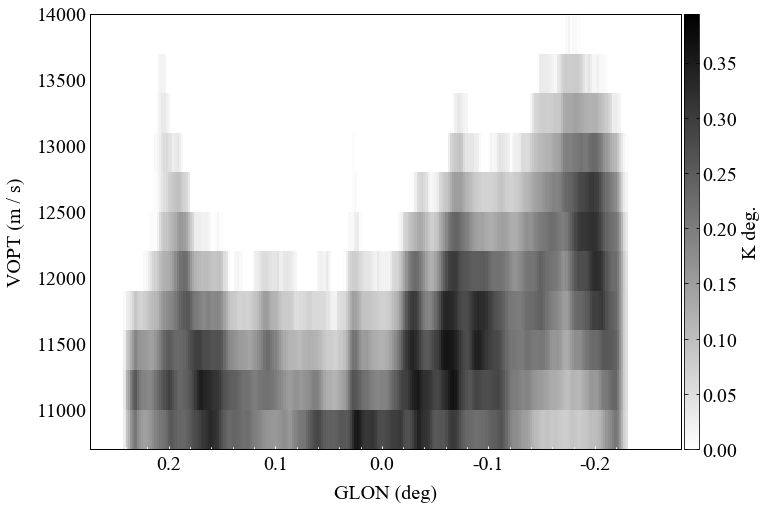

In [12]:
f = plt.figure(figsize=(24, 8))
#plt.subplots_adjust(wspace=0.27, hspace=0.6)
f = aplpy.FITSFigure(cubemap_pv.hdu, subplot=(1, 2, 1), figure=f)
f.show_colorscale(vmin=0,aspect='auto',cmap='gray_r')
f.add_colorbar()
f.colorbar.set_axis_label_text("K deg.")
f.set_xaxis_coord_type('scalar')
f.set_yaxis_coord_type('scalar')
f.savefig('pv_rot.eps') 

In [13]:
_d_fmom=np.array(firstmoment_cube.hdu.data)
_d_smom=np.array(secondmoment_cube.hdu.data)



In [14]:
d_fmom=np.mean(_d_fmom,axis=0)
d_smom=np.mean(_d_smom,axis=0)

(266,)

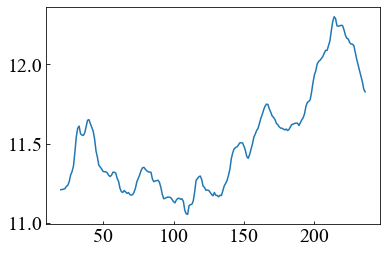

In [15]:
plt.plot(d_fmom)
d_fmom.shape

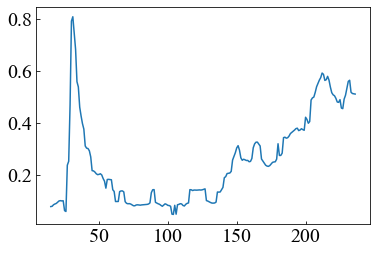

In [16]:
plt.plot(d_smom)

In [19]:
first_wcs=WCS(firstmoment_cube.hdu)
second_wcs=WCS(secondmoment_cube.hdu)

xlist, ylist =first_wcs.wcs_pix2world(np.arange(266), 3, 0)

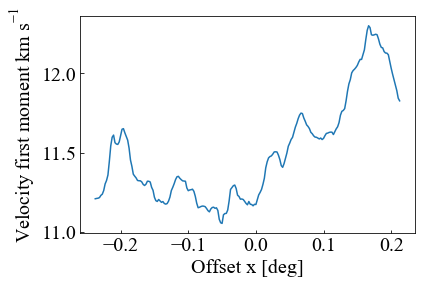

In [20]:
plt.plot(xlist,d_fmom[::-1],label='First moment')
plt.xlabel('Offset x [deg]')
#plt.legend()
plt.ylabel('Velocity first moment km s$^{-1}$')
plt.savefig('gragh_mom1_rot30.eps')

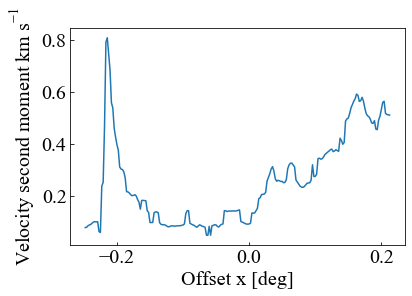

In [21]:
plt.plot(xlist,d_smom[::-1], label='Second moment')
plt.xlabel('Offset x [deg]')
plt.ylabel('Velocity second moment km s$^{-1}$')
plt.savefig('gragh_mom2_rot30.eps')

TypeError: '<' not supported between instances of 'str' and 'int'

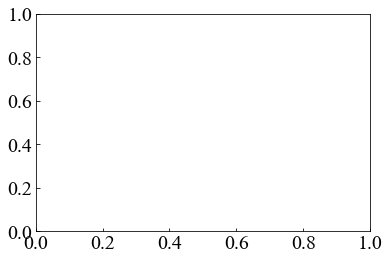

In [22]:
fig,ax = plt.subplots()


f = aplpy.FITSFigure(cubemap.hdu, subplot=(4, 1, '1'),sharex=True,gridspec_kw={'hspace': 0}, figure=fig)
f.show_colorscale(cmap='OrRd',vmin=0,vmax=70)
f.add_colorbar()
f.set_xaxis_coord_type('scalar')
f.set_yaxis_coord_type('scalar')
f.ticks.set_color('black')
f.set_nan_color('grey')
f.colorbar.set_axis_label_text("K km s$^{-1}$")
f.axis_labels.hide_x()
#f.axis_labels.set_xtext('Offset x [deg]')
f.axis_labels.set_ytext('Offset y [deg]')
f.tick_labels.hide_x()

f = aplpy.FITSFigure(cubemap_pv.hdu, subplot=(4, 1, 2),sharex=True, gridspec_kw={'hspace': 0},figure=fig)
f.show_colorscale(vmin=0,aspect='auto',cmap='gray_r')
f.add_colorbar()
f.colorbar.set_axis_label_text("K deg.")
f.set_xaxis_coord_type('scalar')
f.set_yaxis_coord_type('scalar')
f.tick_labels.hide_x()